In [14]:
import cv2
import json
from matplotlib import pyplot as plt
import numpy as np
import os
import random
import keras

# import a lot of things from keras:
# sequential model
from keras.models import Sequential

# layers
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, RandomFlip, RandomRotation, RandomContrast, RandomBrightness

# loss function
from keras.metrics import categorical_crossentropy

# callback functions
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# convert data to categorial vector representation
from keras.utils import to_categorical

# nice progress bar for loading data
from tqdm.notebook import tqdm

# helper function for train/test split
from sklearn.model_selection import train_test_split

# import confusion matrix helper function
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# import pre-trained model
from keras.applications.vgg16 import VGG16

# include only those gestures
CONDITIONS = ['like', 'stop', 'dislike', 'rock', 'peace']

# image size
IMG_SIZE = 64
SIZE = (IMG_SIZE, IMG_SIZE)

# number of color channels we want to use
# set to 1 to convert to grayscale
# set to 3 to use color images
COLOR_CHANNELS = 3

## helper function to load and parse annotations

In [15]:
annotations = dict()

for condition in CONDITIONS:
    with open(f'annot-hoessl.json') as f:
        annotations[condition] = json.load(f)

## helper function to pre-process images (color channel conversion and resizing)

In [16]:
def preprocess_image(img):
    if COLOR_CHANNELS == 1:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img, SIZE)
    return img_resized

## load images and annotations

In [17]:
images = [] # stores actual image data
labels = [] # stores labels (as integer - because this is what our network needs)
label_names = [] # maps label ints to their actual categories so we can understand predictions later

# loop over all conditions
# loop over all files in the condition's directory
# read the image and corresponding annotation
# crop image to the region of interest
# preprocess image
# store preprocessed image and label in corresponding lists
for condition in CONDITIONS:
    for filename in tqdm(os.listdir(condition)):
        # extract unique ID from file name
        UID = filename.split('.')[0]
        img = cv2.imread(f'{condition}/{filename}')
        
        # get annotation from the dict we loaded earlier
        try:
            annotation = annotations[condition][UID]
        except Exception as e:
            print(e)
            continue
        
        # iterate over all hands annotated in the image
        for i, bbox in enumerate(annotation['bboxes']):
            # annotated bounding boxes are in the range from 0 to 1
            # therefore we have to scale them to the image size
            x1 = int(bbox[0] * img.shape[1])
            y1 = int(bbox[1] * img.shape[0])
            w = int(bbox[2] * img.shape[1])
            h = int(bbox[3] * img.shape[0])
            x2 = x1 + w
            y2 = y1 + h
            
            # crop image to the bounding box and apply pre-processing
            crop = img[y1:y2, x1:x2]
            preprocessed = preprocess_image(crop)
            
            # get the annotated hand's label
            # if we have not seen this label yet, add it to the list of labels
            label = annotation['labels'][i]
            if label not in label_names:
                label_names.append(label)
            
            label_index = label_names.index(label)
            
            images.append(preprocessed)
            labels.append(label_index)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

## let's have a look at one of the images

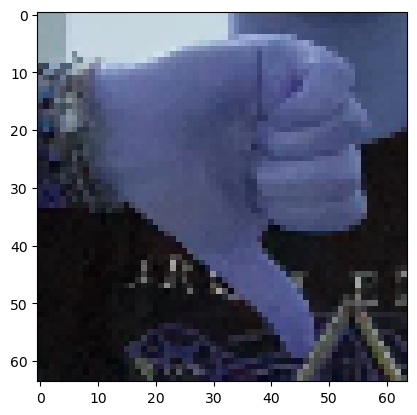

In [41]:
plt.imshow(random.sample(images, 1)[0])

## load CNN



In [19]:
model = keras.models.load_model("../gesture_recognition_cnn")

## visualize classification results with a confusion matrix

In [20]:
X_test = images
y_test = labels

print(len(X_test))
print(len(y_test))

20
20


In [21]:
X_test = np.array(X_test).astype('float32')
X_test = X_test / 255.

y_test_one_hot = to_categorical(y_test)

test_label = y_test_one_hot

#X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)
X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)

print(X_test.shape, test_label.shape)

(20, 64, 64, 3) (20, 6)


1/1 [==============================] - 0s 93ms/step
before [[6.15722477e-01 3.12989503e-01 6.93064108e-02 9.36985634e-06
  1.51788136e-05 1.95707055e-03]
 [1.07917655e-02 9.88564789e-01 6.72230672e-05 5.29693149e-04
  1.73959904e-06 4.47605344e-05]
 [1.00000000e+00 3.89531607e-09 2.19442997e-09 1.41937791e-17
  2.25630857e-19 1.81112521e-15]
 [3.64685420e-08 9.99999881e-01 2.75511919e-10 9.94083891e-08
  1.12495135e-09 1.35215372e-11]
 [1.46520961e-05 9.18726528e-07 9.94757950e-01 1.26494826e-09
  8.52919402e-05 5.14107710e-03]
 [9.02260542e-02 9.15301440e-04 9.08741295e-01 4.64434925e-05
  1.91963204e-06 6.90726229e-05]
 [3.87363404e-01 7.01833269e-05 6.12566292e-01 4.76201523e-09
  7.45148221e-10 1.64328867e-07]
 [3.08161163e-10 1.00000000e+00 3.06175896e-12 1.72254745e-11
  6.05094447e-12 2.88256768e-15]
 [6.32774909e-12 8.87285933e-05 7.55208274e-14 9.99911308e-01
  1.18189278e-11 1.54345287e-11]
 [4.04367165e-12 3.46007425e-07 3.04152314e-10 9.99999642e-01
  3.14801685e-10 1.31732

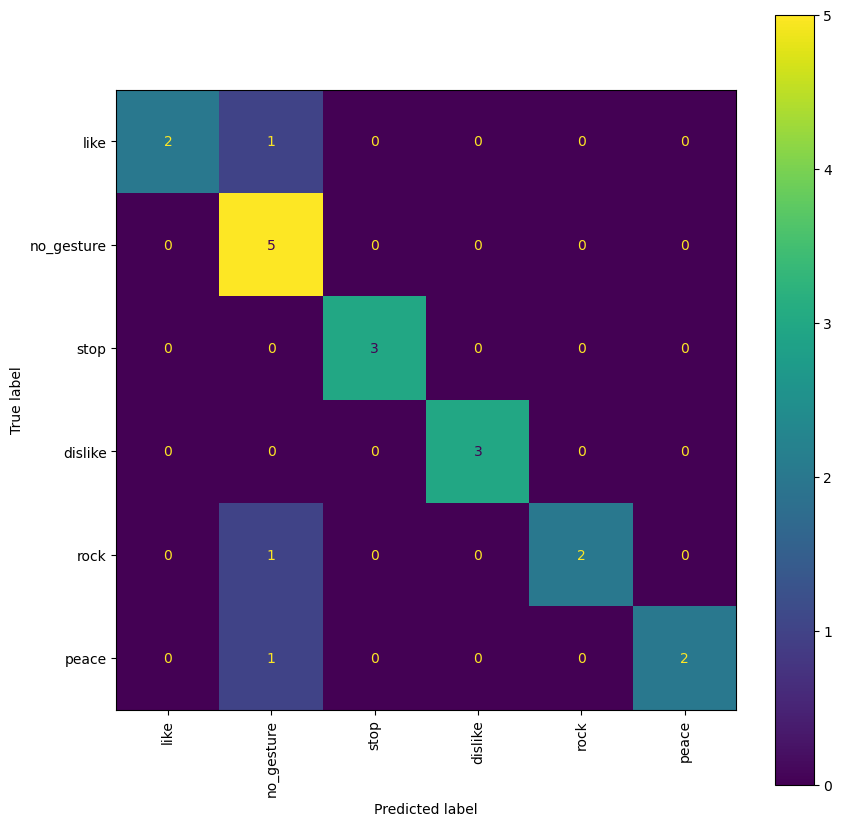

In [22]:
# let the model make predictions for our training data
y_predictions = model.predict(X_test)

# we get a 2D numpy array with probabilities for each category
print('before', y_predictions)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

print('probabilities', y_predictions)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass